**-----------------------------------------------------------------MOVIE RECOMMENDER SYSTEM-----------------------------------------------------------------**<br>
Content + Collaborative Filtering<br>
Dataset: movies small dataset<br>


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import pickle

In [5]:
path= 'data/'
movies= pd.read_csv(path + 'movies.csv')
rating= pd.read_csv(path + 'ratings.csv')
tag= pd.read_csv(path + 'tags.csv')

In [7]:
movies.head(5) #user/movie id & ratings

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [8]:
tag.head(5)    #tags given by user

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [9]:
movies['genres'] = movies['genres'].str.replace('|', ' ')

C:\Users\yashvi\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  """Entry point for launching an IPython kernel.


In [10]:
len(movies.movieId.unique())

9742

In [11]:
len(rating.movieId.unique())

9724

In [12]:
#limiting ratings to user that have rated more than 55 movies 
#this helps to reduce data espically during collaborative filtering 
ratings_f= rating.groupby('userId').filter(lambda x: len(x)>=55) 
movie_list_rating= ratings_f.movieId.unique().tolist() #extracting movie that survie above

In [13]:
len(ratings_f.movieId.unique()) / len(movies.movieId.unique()) * 100 
#will tell how many movies we have retained from above filtering
#Therefore 97 % movies are retained

98.7990145760624

In [14]:
len(ratings_f.userId.unique()) / len(rating.userId.unique()) * 100 
#will tell how many users we have retained from above filtering
#Therefore 59 % movies are retained and we have reduced 41% of user data

59.67213114754099

In [15]:
movies= movies[movies.movieId.isin(movie_list_rating)] #movie dataframe

In [16]:
movies.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure Children Fantasy
2,3,Grumpier Old Men (1995),Comedy Romance
3,4,Waiting to Exhale (1995),Comedy Drama Romance
4,5,Father of the Bride Part II (1995),Comedy


In [17]:
mapping= dict(zip(movies.title.tolist(), movies.movieId.tolist()))

In [18]:
tag.drop(['timestamp'], 1, inplace=True)
ratings_f.drop(['timestamp'], 1, inplace=True)

MERGING OF MOVIES AND TAG DATASET
For content filtering we need: 1) genre (movie dataset) 2) tag (tag datset)

In [19]:
mixed= pd.merge(movies, tag, on='movieId', how='left')
mixed.head(5)

,movieId,title,genres,userId,tag
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,336.0,pixar
1,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,474.0,pixar
2,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,567.0,fun
3,2,Jumanji (1995),Adventure Children Fantasy,62.0,fantasy
4,2,Jumanji (1995),Adventure Children Fantasy,62.0,magic board game


In [20]:
#a movie has many tags & genere hence we combine them to form metadata
mixed.fillna('',inplace= True)
mixed= pd.DataFrame(mixed.groupby('movieId')['tag'].apply(lambda x: '%s' % ' '.join(x)))
Final= pd.merge(movies, mixed, on='movieId', how='left')
Final ['metadata'] = Final[['tag', 'genres']].apply(lambda x: ' '.join(x), axis=1)

In [21]:
Final.head(5)

,movieId,title,genres,tag,metadata
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,pixar pixar fun,pixar pixar fun Adventure Animation Children C...
1,2,Jumanji (1995),Adventure Children Fantasy,fantasy magic board game Robin Williams game,fantasy magic board game Robin Williams game A...
2,3,Grumpier Old Men (1995),Comedy Romance,moldy old,moldy old Comedy Romance
3,4,Waiting to Exhale (1995),Comedy Drama Romance,,Comedy Drama Romance
4,5,Father of the Bride Part II (1995),Comedy,pregnancy remake,pregnancy remake Comedy


In [22]:
Final.shape

(9625, 5)

----------------------------------------*CREATING A CONTENT LATENT MATRIX FROM MOVIE METADATA* (CONTENT BASED)----------------------------------------

TF-IDF method Tf- Term frequency IDF- Inverse document frequency.
**is a method which gives us a numerical weightage of words which reflects how important the particular word is to a document**

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf= TfidfVectorizer(stop_words='english')
matrix= tfidf.fit_transform(Final['metadata'])
tfidf_df= pd.DataFrame(matrix.toarray(), index= Final.index.tolist())

In [24]:
tfidf_df.head(5) #each movie has aroud 1674 vector(words) #will give a sparse dataset

,0,1,2,3,4,5,6,7,8,9,...,1665,1666,1667,1668,1669,1670,1671,1672,1673,1674
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
tfidf_df.shape  

(9625, 1675)

Here for each movie we have around 1675 vectors (this might be less but when bigger dataset is used the vector incecreaces) hence it needs to be reduced

In [36]:
from sklearn.decomposition import TruncatedSVD
svd= TruncatedSVD(n_components= 150)   #the first 150 components give 80% variance 
latent_matrix= svd.fit_transform(tfidf_df) #minimum feature but more variance of data

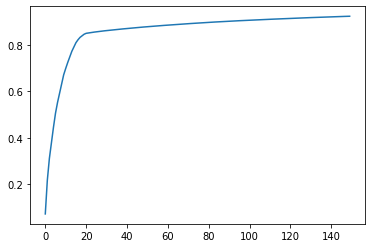

In [37]:
explain= svd.explained_variance_ratio_.cumsum()
plt.plot(explain)

In [39]:
latent_matrix

array([[ 1.02599537e-01,  8.23700619e-02,  6.94586762e-02, ...,
        -3.85249156e-02, -5.88739521e-03, -1.42824076e-01],
       [ 3.26891287e-02,  8.53905589e-03,  5.91889418e-02, ...,
         7.48792271e-03, -9.26994043e-03, -9.89714582e-03],
       [ 1.48118479e-01,  1.05052188e-01, -4.23184029e-02, ...,
        -1.78285725e-04,  2.26402967e-03,  3.89981572e-04],
       ...,
       [ 6.31675485e-01, -6.67342183e-01, -3.01957893e-01, ...,
        -4.45602837e-05,  2.62673966e-04, -2.33785021e-04],
       [ 1.14017796e-01, -1.32122037e-02,  3.37757176e-01, ...,
         3.38432521e-04,  3.53538948e-04,  5.90829661e-04],
       [ 6.60984490e-01,  7.06434480e-01, -3.80688894e-02, ...,
         1.39396115e-04, -1.71473412e-04, -6.68875963e-05]])

In [41]:
latent_matrix.shape #reduced 1674 varaince to 150

(9625, 150)

In [47]:
latent_matrix_1_df= pd.DataFrame(latent_matrix[:, 0:200], index= Final.title.tolist())
latent_matrix_1_df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
Toy Story (1995),0.102600,0.082370,0.069459,0.091250,-0.151136,0.012090,0.234567,-0.019392,-0.124586,-0.008614,...,0.016569,-0.010949,0.123159,-0.165678,0.094215,-0.056585,0.089650,-0.038525,-0.005887,-0.142824
Jumanji (1995),0.032689,0.008539,0.059189,0.091842,-0.106015,0.007100,0.189676,-0.012325,-0.078054,0.001669,...,-0.003924,-0.002687,-0.000232,0.010980,0.000769,-0.000539,0.005225,0.007488,-0.009270,-0.009897
Grumpier Old Men (1995),0.148118,0.105052,-0.042318,0.121888,0.098552,-0.040117,-0.011973,0.000952,0.004727,-0.002093,...,0.002142,0.001725,0.001557,-0.000966,0.001876,-0.000821,-0.003284,-0.000178,0.002264,0.000390


-------------------*CREATING A COLLABORATIVE LATENT MATRIX FROM MOVIE **RATING*** (COLLABORATIVE BASED)-----------------

In [43]:
ratings_f.head(5)

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [44]:
ratings_f1= pd.merge(movies[['movieId']], ratings_f, on="movieId", how="right")

In [46]:
ratings_f2= ratings_f1.pivot(index="movieId", columns="userId", values="rating").fillna(0)
ratings_f2.head(2)

userId,1,4,6,7,10,11,15,16,17,18,...,600,601,602,603,604,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,4.5,0.0,0.0,2.5,0.0,4.5,3.5,...,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0


In [48]:
svd= TruncatedSVD(n_components= 150)   #the first 150 components give 80% variance
latent_matrix_2= svd.fit_transform(ratings_f2)  

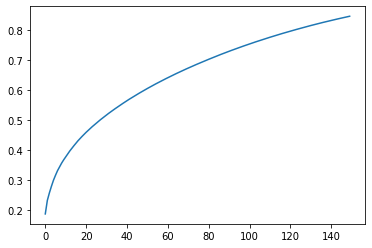

In [51]:
explain= svd.explained_variance_ratio_.cumsum()
plt.plot(explain)

In [50]:
latent_matrix_2_df= pd.DataFrame(latent_matrix_2[:, 0:200], index= Final.title.tolist())
latent_matrix_2_df.shape

(9625, 150)

**----------------------------------------A CONTENT/COLLABORATIVE HYBRID USING COSINE SIMILARITY----------------------------------------**

In [52]:
#content based matrix:
latent_matrix_1_df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
Toy Story (1995),0.102600,0.082370,0.069459,0.091250,-0.151136,0.01209,0.234567,-0.019392,-0.124586,-0.008614,...,0.016569,-0.010949,0.123159,-0.165678,0.094215,-0.056585,0.089650,-0.038525,-0.005887,-0.142824
Jumanji (1995),0.032689,0.008539,0.059189,0.091842,-0.106015,0.00710,0.189676,-0.012325,-0.078054,0.001669,...,-0.003924,-0.002687,-0.000232,0.010980,0.000769,-0.000539,0.005225,0.007488,-0.009270,-0.009897


In [53]:
#collaborative filtering based matrix
latent_matrix_2_df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
Toy Story (1995),36.391240,-4.958788,14.33182,1.844155,-3.077918,-1.351167,8.341410,-0.561104,-1.898191,1.657880,...,-2.886543,-0.084969,2.466129,0.622203,-1.446694,0.367953,-0.503749,-2.060325,-1.157156,-1.878092
Jumanji (1995),20.447499,0.675231,11.35448,-7.325453,-3.505242,3.585611,4.393399,-5.564569,0.434463,0.351474,...,0.122543,0.277666,-0.035064,1.454299,0.921367,2.364011,-1.230592,-0.112557,0.377783,-0.211297


In [72]:
from sklearn.metrics.pairwise import cosine_similarity

#latent feature + movie to get similarities bwtween that movie with others
cb= np.array(latent_matrix_1_df.loc['Toy Story (1995)']).reshape(1, -1)
cf= np.array(latent_matrix_2_df.loc['Toy Story (1995)']).reshape(1, -1)

score1= cosine_similarity(latent_matrix_1_df, cb).reshape(-1)
score2= cosine_similarity(latent_matrix_2_df, cf).reshape(-1)

hybrid= ((score1+score2)/2.0)

In [73]:
df= {'content': score1, 'collaborative': score2, 'hybrid': hybrid}
similar= pd.DataFrame(df, index=latent_matrix_1_df.index)

In [74]:
#sorted based on content (genre) similar to toy story 
similar.sort_values('content', ascending=False, inplace=True)
similar.head(10)

,content,collaborative,hybrid
Balto (1995),1.0,1.000000,1.000000
Brother Bear (2003),1.0,0.270458,0.635229
Ice Age: A Mammoth Christmas (2011),1.0,0.005802,0.502901
Dinosaur (2000),1.0,0.235245,0.617623
"Rescuers Down Under, The (1990)",1.0,0.281080,0.640540
Pocahontas II: Journey to a New World (1998),1.0,0.393205,0.696602
Digimon: The Movie (2000),1.0,-0.004015,0.497993
Gulliver's Travels (1939),1.0,-0.029125,0.485437
Adventures of Mowgli: The Kidnapping (1968),1.0,-0.001763,0.499119
Karlson Returns (1970),1.0,-0.001763,0.499119


In [65]:
#sorted based on rating i.e similar users 
similar.sort_values('collaborative', ascending=False, inplace=True)
similar.head(10)

,content,collaborative,hybrid
Toy Story (1995),1.000000,1.000000,1.000000
Jurassic Park (1993),0.129339,0.735622,0.432481
Toy Story 2 (1999),0.808260,0.713696,0.760978
Forrest Gump (1994),0.106727,0.703799,0.405263
Shrek (2001),0.653571,0.703753,0.678662
Apollo 13 (1995),0.046104,0.697499,0.371802
Star Wars: Episode IV - A New Hope (1977),0.081791,0.685311,0.383551
Star Wars: Episode VI - Return of the Jedi (1983),0.069927,0.682572,0.376249
Aladdin (1992),0.383429,0.677676,0.530552
"Lion King, The (1994)",0.164173,0.667720,0.415947


In [66]:
#sorted based on hybrid
similar.sort_values('hybrid', ascending=False, inplace=True)
similar.head(10)

,content,collaborative,hybrid
Toy Story (1995),1.000000,1.000000,1.000000
Toy Story 2 (1999),0.808260,0.713696,0.760978
"Bug's Life, A (1998)",0.862957,0.631158,0.747057
Shrek (2001),0.653571,0.703753,0.678662
"Monsters, Inc. (2001)",0.690562,0.639359,0.664961
Antz (1998),0.690562,0.471063,0.580812
Ice Age (2002),0.605404,0.514545,0.559975
Who Framed Roger Rabbit? (1988),0.564284,0.539763,0.552024
Toy Story 3 (2010),0.565642,0.519787,0.542714
Space Jam (1996),0.580923,0.488064,0.534494


**----------------------------------------User enters data----------------------------------------**

In [77]:
movie= input("Enter a movie you have seen: ")
cb= np.array(latent_matrix_1_df.loc[movie]).reshape(1, -1)
cf= np.array(latent_matrix_2_df.loc[movie]).reshape(1, -1)

score1= cosine_similarity(latent_matrix_1_df, cb).reshape(-1)
score2= cosine_similarity(latent_matrix_2_df, cf).reshape(-1)

hybrid= ((score1+score2)/2.0)

df= {'content': score1, 'collaborative': score2, 'hybrid': hybrid}
similar= pd.DataFrame(df, index=latent_matrix_1_df.index)

similar.sort_values('hybrid', ascending=False, inplace=True)
similar.head(10)


,content,collaborative,hybrid
Balto (1995),1.000000,1.000000,1.000000
Tarzan (1999),0.958624,0.441120,0.699872
Pocahontas II: Journey to a New World (1998),1.000000,0.393205,0.696602
"American Tail, An (1986)",0.952273,0.372429,0.662351
"Black Cauldron, The (1985)",0.865396,0.455453,0.660424
We're Back! A Dinosaur's Story (1993),0.865396,0.426377,0.645886
Cats Don't Dance (1997),0.665963,0.623925,0.644944
Oliver & Company (1988),0.785143,0.500269,0.642706
"Rescuers Down Under, The (1990)",1.000000,0.281080,0.640540
Brother Bear (2003),1.000000,0.270458,0.635229


In [71]:
score1

array([ 5.76769272e-01,  2.57853369e-01, -1.10381306e-04, ...,
       -4.18062729e-07,  5.07141364e-01,  9.38729394e-07])